## Automating Summary Research Tables with ChatGPT and Python

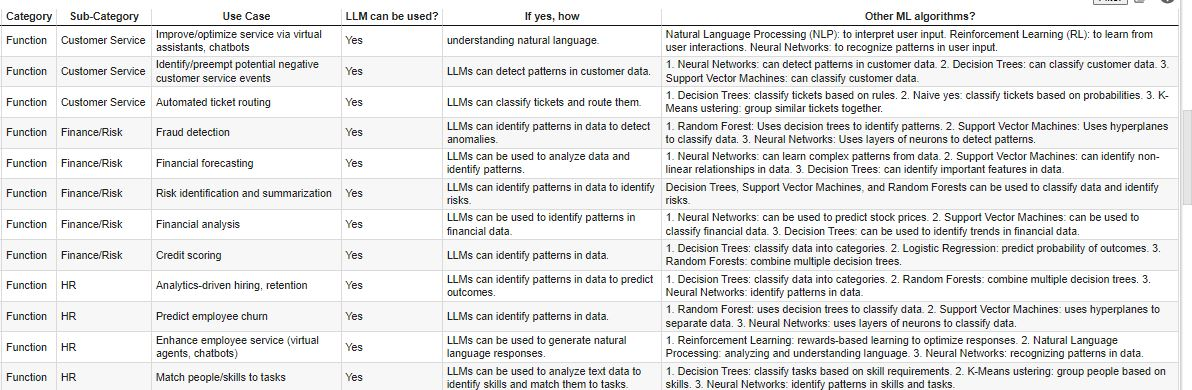

When it comes to research efforts, ChatGPT can be an incredible force multiplier. Just type in a question and ChatGPT returns hundreds of words that you can quickly copy, paste into a word processing tool and tailor to your needs.  

That's great. But what about a research project seeking concise, high-level answers across a long list of items? The type of research that is usually communicated via summary research tables.  

Here, copy-and-paste would be incredibly tedious and time consuming.  

Fortunately, you can use a combination of ChatGPT, Python and Excel to automate the process. This notebook show how it might be done.  

### Manual and Automated Processes
My project starts with a list of business and organizational use cases for AI and machine learning algorithms that I have maintained for some time, using a simple Excel spreadsheet. The list is broken into functional areas (e.g., Marketing, HR, Legal) and industries (e.g., Agriculture, Healthcare, High-Tech).  

I could have automated this initial process by asking ChatGPT to provide a list of a dozen or so functional areas and industries, and then requesting use cases for each category. But since I already had curated information, I simply asked ChatGPT to suggest any changes. I agreed with some of the edits, and manually made them to the spreadsheet.  

But in addition to identifying use cases, I wanted to expand my table to include examples of which machine learning algorithms (e.g., logistic regression, decision trees) best support each use case. In particular, with the emergence of large language models (LLMs), I wanted to ask how they might be applied to each use case.  

The code below automates this part of the process. Of course, the choice of where to draw the line between manual and automated processes will depend on your own needs and circumstances.

### Getting started

First, we install necessary libraries and import them into our environment.

In [ ]:
! pip install openai
! pip install requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
import os
import openai
import requests
import pandas as pd

To use ChatGPT via OpenAI's API, you will need to sign up and request an API key. (OpenAI is the company behind ChatGPT.)

*   Go to OpenAI's Platform website at [platform.openai.com](https://) and select "Sign up" in the top-right corner.
*  Once you have an account, click your profile icon at the top-right corner of the page and select "View API Keys."  
*   Click "Create New Secret Key" to generate a new API key.
*   Save the API key.

In [ ]:
# Set an environmental variable for OpenAI key
os.environ['OPENAI_API_KEY'] = 'your-api-key-here'

### Functions  

Our first function (*def build_prompt*) constructs the prompt. It feeds  each use case description (e.g., "Fraud detection") into a series of three questions about supporting algorithms. Each question is carefully delineated and provides specific guidance on what output is expected.

In [ ]:
def build_prompt(use_case):
    """
    Constructs a prompt to be sent to the OpenAI API based on a given use case.

    Args:
        use_case (str): The use case to construct a prompt for.

    Returns:
        str: The constructed prompt.
    """
    prompt = f"""
    A. Can Large Language Models (LLMs) be used for {use_case}? Answer Yes or No.
    B. If yes, how can LLMs be utilized for {use_case}? Answer in 15 words or less. If No, say NA.
    C. What other machine learning algorithms could be suitable for {use_case}? Name 1-3 algorithms and very briefly explain each (10 words each maximum).
    ---
    """
    print(prompt)  # For testing
    return prompt

Here is an example of the fully constructed prompt:

    A. Can Large Language Models (LLMs) be used for Fraud detection? Answer Yes or No.

    B. If yes, how can LLMs be utilized for Fraud detection? Answer in 15 words or less. If No, say NA.

    C. What other machine learning algorithms could be suitable for Fraud detection? Name 1-3 algorithms and very briefly explain each (10 words each maximum).  

The function *get_openai_data* (see below) takes a given prompt and forwards it to the OpenAI API for a response.  

We set the temperature to 0.2 to promote deterministic answers, meaning there's minimal variation or creativity in the responses (1.0 represents maximum creativity).  

Also note that the results are parsed to align with our three questions. Typically, but not always, ChatGPT adds a newline character (\n) to the end of each question in a series, if they are clearly delineated. That was our reason for constructing the prompt with three distinct questions.

The response is delivered back from ChatGPT as a dictionary. Here is an example:

  {'LLM can be used?': 'A. Yes', 'If yes, how': 'B. LLMs can identify patterns in data to detect anomalies.', 'Other ML algorithms?': 'C. 1. Random Forest: Uses decision trees to identify patterns. 2. Support Vector Machines: Uses hyperplanes to classify data. 3. Neural Networks: Uses layers of neurons to detect patterns.'}




In [ ]:
def get_openai_data(prompt):
    """
    Sends a prompt to the OpenAI GPT-3.5 engine to receive a completion.

    This function sets the OpenAI API key from an environmental variable,
    sends the provided prompt to the GPT-3.5 engine, extracts the response,
    and returns a structured dictionary containing the extracted information.

    Parameters:
    prompt (str): The text prompt to send to the GPT-3.5 engine for completion.

    Returns:
    dict: A dictionary with keys 'LLM can be used?', 'If yes, how', and 'Other ML algorithms?'.
          Each key corresponds to a line of text extracted from the GPT-3.5 response.

    Raises:
    - Various exceptions can be raised due to issues with the OpenAI API call,
      such as a missing API key, network issues, or an invalid prompt.

    Example:
    >>> get_openai_data("Describe the use of LLM in sentiment analysis.")
    {'LLM can be used?': 'Yes', 'If yes, how': 'By analyzing text to determine sentiment', 'Other ML algorithms?': 'SVM, Naive Bayes'}

    Notes:
    - Ensure the OPENAI_API_KEY environmental variable is set before calling this function.
    - The function assumes that the OpenAI response contains three lines of text separated by newlines.
    """
    openai.api_key = os.environ["OPENAI_API_KEY"]

    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=prompt,
        max_tokens=200,  # Adjust the max tokens to accommodate all three answers
        temperature = 0.2 # Adjust temperature to make output more focused and deterministic (by dialing lower)
    )
    # Assume that the responses are separated by newlines, adjust if necessary
    response_data = response.choices[0].text.strip().split('\n') if response.choices else ['', '', '']
    # print(response_data)  # Print the returned data; for Testing

    print({
        'LLM can be used?': response_data[0] if len(response_data) > 0 else '',
        'If yes, how': response_data[1] if len(response_data) > 1 else '',
        'Other ML algorithms?': response_data[2] if len(response_data) > 2 else ''
    })

    return {
        'LLM can be used?': response_data[0] if len(response_data) > 0 else '',
        'If yes, how': response_data[1] if len(response_data) > 1 else '',
        'Other ML algorithms?': response_data[2] if len(response_data) > 2 else ''
    }

The next function (*process_data*) takes our use cases in groups of ten, constructs the prompts, gets the ChatGPT responses and places them in the appropriate columns of the dataframe.   

The following function (*clean_dataframe*) removes our "A-B-C" question ordering convention, which is no longer needed for delineation, as the text is now parsed out into three columns of the dataframe. The clean-up function also removes any extra white space at the beginning or end of each response. Other clean-up instructions, depending on your needs, could be added here.

In [ ]:
def process_data(df):
    """
    Processes a DataFrame of use case data, fetching additional data from the OpenAI API for each use case.

    Args:
        df (pd.DataFrame): The DataFrame containing the use case data.

    Returns:
        pd.DataFrame: The updated DataFrame with additional data.
    """
    for i in range(0, len(df), 10):
        chunk = df[i:i+10]
        for index, row in chunk.iterrows():
            prompt = build_prompt(row['Use Case'])
            use_case_data = get_openai_data(prompt)
            df.at[index, 'LLM can be used?'] = use_case_data['LLM can be used?']
            df.at[index, 'If yes, how'] = use_case_data['If yes, how']
            df.at[index, 'Other ML algorithms?'] = use_case_data['Other ML algorithms?']
    df = clean_dataframe(df)
    return df

In [ ]:
def clean_dataframe(df):
    """
    Cleans specified columns in the provided DataFrame by removing known prefixes and
    stripping leading and trailing whitespace.

    The function specifically targets the columns 'LLM can be used?', 'If yes, how',
    and 'Other ML algorithms?' for cleaning.

    Args:
        df (pd.DataFrame): The DataFrame to be cleaned.

    Returns:
        pd.DataFrame: The cleaned DataFrame.
    """
    # List of columns to clean
    columns_to_clean = ['LLM can be used?', 'If yes, how', 'Other ML algorithms?']

    for column in columns_to_clean:
        df[column] = df[column].str.replace('A.', '')
        df[column] = df[column].str.replace('B.', '')
        df[column] = df[column].str.replace('C.', '')
        df[column] = df[column].str.strip()
    return df


### Main Program and Output

Lastly, our main program brings everything together. It starts by reading our original spreadsheet (i.e., just the use cases and whether they refer to functions or industries) into a dataframe. It then calls the process_data function, which launches the end-to-end process from prompt creation to dataframe insertion. It also creates a new, updated Excel spreadsheet from the dataframe, for further hands-on editing and manipulation.

In [ ]:
# Run main program and assign output to dataframe for possible additional review/manipulation in Python; save dataframe to pkl and xlsx files
if __name__ == "__main__":
    file_path = 'master_compendium_scrape_shell.xlsx'  # Update path as needed
    df = pd.read_excel(file_path)
    print(df.head())
    df = process_data(df)
    print(df) # For testing
    df.to_pickle("research_data.pkl") # For dataframe re-use
    df.to_excel("research_data.xlsx", index=False)

   Category     Sub-Category   \
0  Function  Customer Service   
1  Function  Customer Service   
2  Function  Customer Service   
3  Function      Finance/Risk   
4  Function      Finance/Risk   

                                            Use Case  
0  Improve/optimize service via virtual assistant...  
1  Identify/preempt potential negative customer s...  
2                          Automated ticket routing   
3                                    Fraud detection  
4                              Financial forecasting  

    A. Can Large Language Models (LLMs) be used for Improve/optimize service via virtual assistants, chatbots? Answer Yes or No.
    B. If yes, how can LLMs be utilized for Improve/optimize service via virtual assistants, chatbots? Answer in 15 words or less. If No, say NA.
    C. What other machine learning algorithms could be suitable for Improve/optimize service via virtual assistants, chatbots? Name 1-3 algorithms and very briefly expain each (10 words each maxi

<ipython-input-7-69f41e7f0d1a>:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace('A.', '')
<ipython-input-7-69f41e7f0d1a>:20: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace('B.', '')
<ipython-input-7-69f41e7f0d1a>:21: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace('C.', '')


Below is how the completed datframe looks.  Further manipulation can be done either in Python or Excel.

This demo research project covered 100+ use cases and delivered a completed spreadsheet in a few minutes. Manually cutting and pasting the information would have taken days. And developing the underlying information without ChatGPT (or other large language model) would likely have taken weeks.  

Businesses and organizations often produce summary tables that present concise, high-level findings or comparisons. An accounting firm, for example, might want a summary of how dozens of different jurisdictions treat a certain tax matter. Or a manufacturer might want to compare features of products in its portfolio against those of competitors around the world. While the output from automating research with ChatGPT and Python no doubt needs human validation and refinement, the process can easily save weeks or months of work.



In [ ]:
df.head(25)

,Category,Sub-Category,Use Case,LLM can be used?,"If yes, how",Other ML algorithms?
0,Function,Customer Service,Improve/optimize service via virtual assistant...,Yes,LLMs can be used to generate more natural conv...,1. Reinforcement Learning: to optimize rewards...
1,Function,Customer Service,Identify/preempt potential negative customer s...,Yes,LLMs can detect patterns in customer data.,1. Decision Trees: classify customer data. 2. ...
2,Function,Customer Service,Automated ticket routing,Yes,LLMs can classify tickets to route them.,1. Decision Trees: classify tickets based on a...
3,Function,Finance/Risk,Fraud detection,Yes,LLMs can identify patterns in data to detect a...,1. Random Forest: uses decision trees to ident...
4,Function,Finance/Risk,Financial forecasting,Yes,LLMs can be used to analyze data and identify ...,1. Neural Networks: use interconnected layers ...
5,Function,Finance/Risk,Risk identification and summarization,Yes,LLMs can be used to analyze text and identify ...,1. Naive yes: uses probability to classify dat...
6,Function,Finance/Risk,Financial analysis,Yes,LLMs can be used to identify patterns and tren...,1. Neural Networks: used to identify complex r...
7,Function,Finance/Risk,Credit scoring,Yes,LLMs can identify patterns in data.,1. Decision Trees: classify data into categori...
8,Function,HR,"Analytics-driven hiring, retention",Yes,LLMs can identify patterns in data to predict ...,1. Decision Trees: classify data into categori...
9,Function,HR,Predict employee churn,Yes,LLMs can identify patterns in data.,1. Decision Trees: classify data into categori...
